## Agricultural Water usage ##


In this experiment we strive to understand and visualize the global agricultural water withdrawal. It is responsible for the largest share of the total water withdrawal and mostly used for irrigated crop harvesting.

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys
import os
import math
from tueplots.constants.color import rgb
from tueplots import bundles
import seaborn as sns
import pandas as pd

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.


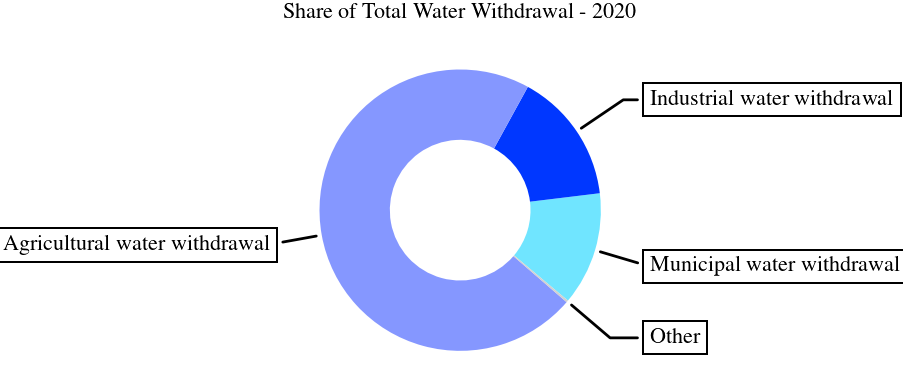

In [164]:
from src.aquastat_utils import get_aquastat
from src.aquastat_utils import plot_world
import geopandas as gpd
from src.utils import to_dat_path
from src.aquastat_utils import rename_aquastat_country

df = get_aquastat()
year = 2020

variables = ['Total water withdrawal', 'Municipal water withdrawal', 'Industrial water withdrawal',
                 'Agricultural water withdrawal']
'''filter countries (no filter if empty)'''


data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
df = data[data['Year'] == year]

# Aggregate data
df = df[['Country', *variables]]

total_water = sum(df['Total water withdrawal'])
municipial_water = sum(df['Municipal water withdrawal'])
industrial_water = sum(df['Industrial water withdrawal'])
agricultural_water = sum(df['Agricultural water withdrawal'])
other = total_water - municipial_water - industrial_water - agricultural_water


fig, ax = plt.subplots(figsize=(4, 2), subplot_kw=dict(aspect="equal"))


categories = ["Municipal water withdrawal",
          "Industrial water withdrawal",
          "Agricultural water withdrawal",
          "Other"]

data = [municipial_water/total_water, industrial_water/total_water, agricultural_water/total_water, other/total_water]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, 
                       colors=['#70E5FF', '#0037FF', '#8597FF', '#D1D1D1'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(categories[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
ax.set_title("Share of Total Water Withdrawal - 2020")

plt.show()


Agricultural water withdrawal

Agricultural water as a share of total water withdrawals, 2019

Agricultural water withdrawal as % of total renewable water resources

Agricultural water withdrawal as % of total water withdrawal

Cultivated area (arable land + permanent crops)


In [156]:
# discrete colormap

def create_discrete_colormap():
    # Define the colors for the colormap
    colors = [(1, 1, 0, 0.3), (0.8, 1, 0.1, 0.5), (0.6, 0.8, 0.2, 0.7), (0.3, 0.6, 0.4, 0.7), (0.2, 0.4, 0.6, 1), (0, 0.2, 0.8, 1), (0, 0.0, 0.8, 1), (0, 0, 0.5, 1)]  # Yellow, Light Blue, Dark Blue
    boundaries = [0, 0.005, 0.01, 0.1, 1, 5, 10, 50, 100]  # Custom boundaries for each color segment

    # Create a colormap using LinearSegmentedColormap
    cmap_name = 'custom_colormap'
    cmap = ListedColormap(colors)

    # Create a norm instance to map data values to the colormap
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    return cmap, norm

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.


Text(0.5, 0.05, 'Source: AQUASTAT')

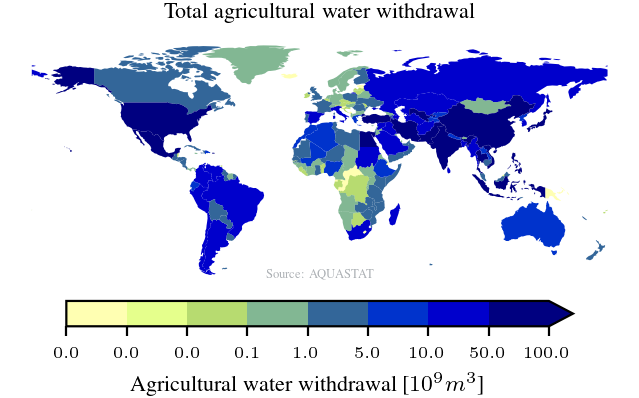

In [157]:
df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Agricultural Water Withdrawal'''
year = 2020
variables = ["Agricultural water withdrawal"]
title = 'Total agricultural water withdrawal'

world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap=custom_cmap, norm = norm,
            legend_kwds={'label': "Agricultural water withdrawal [$10^9 m^3$]", 'orientation': "horizontal",
                        'shrink': 0.8, 'extend': 'max'})

ax.set_title(title)
ax.axis("off")
# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.


Text(0.5, 0.05, 'Source: AQUASTAT')

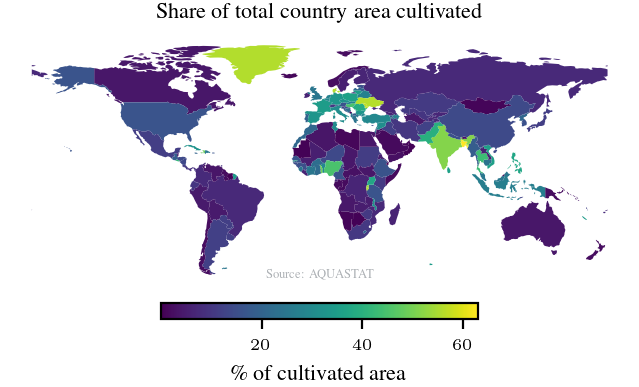

In [158]:
df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Share of total area of a country that is cultivated'''
year = 2020
variables = ["% of total country area cultivated"]
title = 'Share of total country area cultivated'

world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap='viridis',
            legend_kwds={'label': "\% of cultivated area", 'orientation': "horizontal",
                        'shrink': 0.5})

ax.set_title(title)
ax.axis("off")
# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)

In [159]:
# discrete colormap

def create_discrete_colormap():
    # Define the colors for the colormap
    colors = [(0,0,0,0.1), (95/255, 128/255, 194/255, 0.5), (59/255, 113/255, 222/255, 0.78), (13/255, 130/255, 178/255, 0.78), (0, 38/255, 139/255, 0.78)]  # Yellow, Light Blue, Dark Blue
    boundaries = [0, 20, 40, 60, 80, 100]  # Custom boundaries for each color segment

    # Create a colormap using LinearSegmentedColormap
    cmap_name = 'custom_colormap'
    cmap = ListedColormap(colors)

    # Create a norm instance to map data values to the colormap
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    return cmap, norm

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.


Text(0.5, 0.05, 'Source: AQUASTAT')

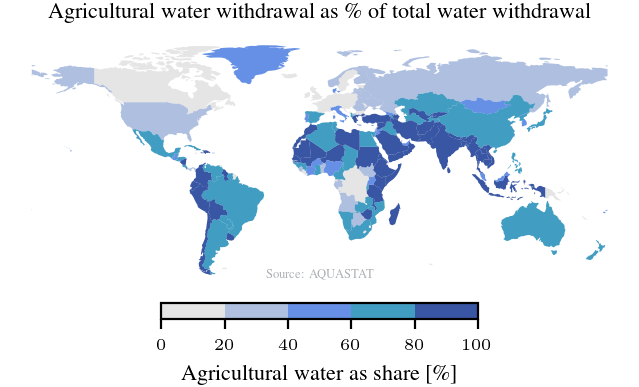

In [160]:
df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Agricultural Water Withdrawal as share of total water withdrawal'''
year = 2020
variables = ["Agricultural water withdrawal as % of total water withdrawal"]
title = 'Agricultural water withdrawal as \% of total water withdrawal'

world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap=custom_cmap, norm = norm,
            legend_kwds={'label': "Agricultural water as share [\%]", 'orientation': "horizontal",
                        'shrink': 0.5})

ax.set_title(title)
ax.axis("off")
# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.


/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/marten/anaconda3/envs/DataLiteracy/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'Water Stress Categories')

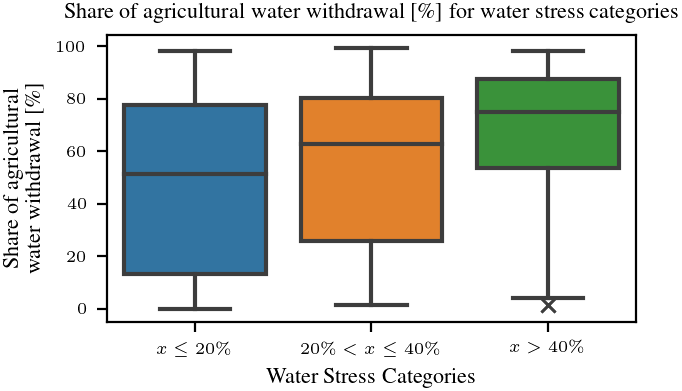

In [161]:
df = get_aquastat()
year = 2020

variables = ['SDG 6.4.2. Water Stress', 'Agricultural water withdrawal as % of total water withdrawal']

data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
df = data[data['Year'] == year]

# Aggregate data
df = df[['Country', *variables]]

# split into two groups based on water stress
# countries with a water stress level above 40% are considered to have high stress
g1 = df[df['SDG 6.4.2. Water Stress'] <= 20]
g2 = df[(df['SDG 6.4.2. Water Stress']<=40) & (df['SDG 6.4.2. Water Stress']>20)]
g3 = df[df['SDG 6.4.2. Water Stress'] > 40]

df = pd.Series(g1['Agricultural water withdrawal as % of total water withdrawal'].to_numpy(), name="$ x \leq 20\%$").to_frame().join(
    pd.Series(g2['Agricultural water withdrawal as % of total water withdrawal'].to_numpy(), name="$20\% < x \leq 40\%$"))
df = df.join(pd.Series(g3['Agricultural water withdrawal as % of total water withdrawal'].to_numpy(), name="$x > 40\%$"))


plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.boxplot(data=df, ax = ax, flierprops={"marker": "x"}) 
ax.set_title("Share of agricultural water withdrawal [\%] for water stress categories")
ax.set_ylabel("Share of agricultural\n water withdrawal [\%]")
ax.set_xlabel("Water Stress Categories")